In [1]:
%cd '/scratch/sk7898/l3embedding/classifier/sonyc_ust'
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import os
import random
import csv
import json
import glob
import pandas as pd
import pickle as pk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import resampy
import tensorflow as tf
import librosa
import keras
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import StandardScaler
from keras.models import load_model
from matplotlib import cm
from metrics import parse_coarse_prediction, micro_averaged_auprc, macro_averaged_auprc, evaluate_df
from classify import load_embeddings, predict_mil, construct_mlp_mil
# New modules: oyaml and pandas
import oyaml as yaml

/scratch/sk7898/l3embedding/classifier/sonyc_ust


Using TensorFlow backend.


In [2]:
# taxonomy = {
#     1: 'engine',
#     2: 'machinery-impact',
#     3: 'non-machinery-impact',
#     4: 'powered-saw',
#     5: 'alert-signal',
#     6: 'music',
#     7: 'human-voice',
#     8: 'dog'
# }

version = 'v0.4'
SONYC_PATH = '/scratch/work/sonyc/sonyc/ust/annotations'
META_FOLDER = '/scratch/sk7898/l3embedding/notebooks/data'
DATA_FOLDER = os.path.join('/scratch/sk7898/l3embedding/notebooks/data', version)
THRESH_DICT = {
    1: 0.8,
    2: 0.2,
    3: 0.2,
    4: 0.2,
    5: 0.8,
    6: 0.1,
    7: 0.3,
    8: 0.1
}

if not os.path.exists(DATA_FOLDER):
    os.makedirs(DATA_FOLDER)

In [3]:
def write_to_output(y_pred, output_path, test_file_list, annotation_data, label_mode, taxonomy):
    
    coarse_fine_labels = [["{}-{}_{}".format(coarse_id, fine_id, fine_label)
                           for fine_id, fine_label in fine_dict.items()]
                          for coarse_id, fine_dict in taxonomy['fine'].items()]
        
    full_fine_target_labels = [fine_label for fine_list in coarse_fine_labels
                               for fine_label in fine_list]
        
    coarse_target_labels = ["_".join([str(k), v])
                            for k, v in taxonomy['coarse'].items()]
    
    annotation = annotation_data.sort_values('audio_filename')[['split', 'sensor_id', 'audio_filename']].drop_duplicates()
    annotation = annotation[annotation['audio_filename'].isin(test_file_list)]
    split_list = annotation['split'].tolist()
    sensor_list = annotation['sensor_id'].tolist()
    
    with open(output_path, 'w') as f:
        csvwriter = csv.writer(f)

        # Write fields
        fields = ["split", "sensor_id", "audio_filename"] + full_fine_target_labels + coarse_target_labels
        csvwriter.writerow(fields)

        # Write results for each file to CSV
        for split, sid, filename, y in zip(split_list, sensor_list, test_file_list, y_pred):
            row = [split, sid, filename]

            if label_mode == "fine":
                fine_values = []
                coarse_values = [0 for _ in range(len(coarse_target_labels))]
                coarse_idx = 0
                fine_idx = 0
                for coarse_label, fine_label_list in zip(coarse_target_labels,
                                                         coarse_fine_labels):
                    for fine_label in fine_label_list:
                        if 'X' in fine_label.split('_')[0].split('-')[1]:
                            # Put a 0 for other, since the baseline doesn't
                            # account for it
                            fine_values.append(0.0)
                            continue

                        # Append the next fine prediction
                        fine_values.append(y[fine_idx])

                        # Add coarse level labels corresponding to fine level
                        # predictions. Obtain by taking the maximum from the
                        # fine level labels
                        coarse_values[coarse_idx] = max(coarse_values[coarse_idx],
                                                        y[fine_idx])
                        fine_idx += 1
                    coarse_idx += 1

                row += fine_values + coarse_values
                
            else:
                # Add placeholder values for fine level
                row += [0.0 for _ in range(len(full_fine_target_labels))]
                # Add coarse level labels
                row += list(y)

            csvwriter.writerow(row)

In [4]:
def filter_ground_truth_split(ann_df, aggregate=True, valid_sensor_ids=None, split_path=None, split=None):
    
    if split and not valid_sensor_ids:
        gt_df = ann_df[(ann_df["annotator_id"] > 0) & (ann_df['split'] == split)]
        #gt_df = ann_df[(ann_df["annotator_id"] == 0) & (ann_df['split'] == split)]
    elif split and valid_sensor_ids:
        gt_df = ann_df[(ann_df["annotator_id"] == 0) & (ann_df['split'] == split) & (ann_df['sensor_id'].isin(valid_sensor_ids))]
    else:
        gt_df = ann_df[ann_df["annotator_id"] == 0]
    
    if aggregate:
        gt_df = gt_df.groupby("audio_filename", group_keys=False).max()
    
    gt_df.reset_index(inplace=True)
    if 'index' in gt_df.keys():
        gt_df = gt_df.drop(columns=['index'])
    return gt_df

In [5]:
def parse_ground_truth(annotation_path, yaml_path, valid_sensor_ids=None, split_path=None, split=None):

    # Create dictionary to parse tags
    with open(yaml_path, 'r') as stream:
        yaml_dict = yaml.load(stream, Loader=yaml.Loader)

    # Load CSV file into a Pandas DataFrame.
    ann_df = pd.read_csv(annotation_path)
    gt_df = filter_ground_truth_split(ann_df,
                                      valid_sensor_ids=valid_sensor_ids,
                                      split_path=split_path,
                                      split=split)

    # Rename coarse columns.
    coarse_dict = yaml_dict["coarse"]
    coarse_renaming = {
        "_".join([str(c), coarse_dict[c], "presence"]): str(c)
        for c in coarse_dict}
    gt_df = gt_df.rename(columns=coarse_renaming)

    # Collect tag names as strings and map them to mixed (coarse-fine) ID pairs.
    # The "mixed key" is a hyphenation of the coarse ID and fine ID.
    fine_dict = {}
    for coarse_id in yaml_dict["fine"]:
        for fine_id in yaml_dict["fine"][coarse_id]:
            mixed_key = "-".join([str(coarse_id), str(fine_id)])
            fine_dict[mixed_key] = yaml_dict["fine"][coarse_id][fine_id]

    # Rename fine columns.
    fine_renaming = {"_".join([k, fine_dict[k], "presence"]): k
        for k in fine_dict}
    gt_df = gt_df.rename(columns=fine_renaming)

    # Loop over coarse tags.
    n_samples = len(gt_df)
    coarse_dict = yaml_dict["coarse"]
    for coarse_id in yaml_dict["coarse"]:
        # Construct incomplete fine tag by appending -X to the coarse tag.
        incomplete_tag = str(coarse_id) + "-X"

        # If the incomplete tag is not in the prediction, append a column of zeros.
        # This is the case e.g. for coarse ID 7 ("dogs") which has a single
        # fine-level tag ("7-1_dog-barking-whining") and thus no incomplete
        # tag 7-X.
        if incomplete_tag not in gt_df.columns:
            gt_df[incomplete_tag] = np.zeros((n_samples,)).astype('int')

    gt_df = gt_df.sort_values('audio_filename')

    gt_df.reset_index(inplace=True)
    if 'index' in gt_df.keys():
        gt_df = gt_df.drop(columns=['index'])

    # Return output in DataFrame format.
    return gt_df

In [6]:
def evaluate_sensor_df(gt_df, pred_df, mode, yaml_dict, split=None):
    
    dicts = {}
    split = split if split else 'validate'
    sids = pred_df[pred_df['split'] == split]['sensor_id'].unique().tolist()
        
    for sid in sids:
        gt = gt_df[(gt_df['split'] == split) & (gt_df['sensor_id'] == sid)]
        pred = pred_df[(pred_df['split'] == split) & (pred_df['sensor_id'] == sid)]
        gt = gt.drop(columns=['split', 'sensor_id'])
        pred = pred.drop(columns=['split', 'sensor_id'])
        dicts[sid] = evaluate_df(gt, pred, mode, yaml_dict)
    return dicts

In [7]:
def evaluate(prediction_path, annotation_path, yaml_path, mode, 
             valid_sensor_ids=None,
             split_path=None, 
             per_sensor=False, 
             split=None):

    with open(yaml_path, 'r') as stream:
        yaml_dict = yaml.load(stream, Loader=yaml.Loader)

    # Parse ground truth.
    gt_df = parse_ground_truth(annotation_path, yaml_path,
                               valid_sensor_ids=valid_sensor_ids,
                               split_path=split_path,
                               split=split)

    # Parse predictions.
    if mode == "fine":
        pred_df = parse_fine_prediction(prediction_path, yaml_path)
    elif mode == "coarse":
        pred_df = parse_coarse_prediction(prediction_path, yaml_path)
    
    flist = [value for value in gt_df['audio_filename'].unique().tolist() 
             if value in pred_df['audio_filename'].unique().tolist()] 
    pred_df = pred_df[pred_df['audio_filename'].isin(flist)]
    gt_df = gt_df[gt_df['audio_filename'].isin(flist)]

    if per_sensor:
        return evaluate_sensor_df(gt_df, pred_df, mode, yaml_dict, split=split)
    else:
        return evaluate_df(gt_df, pred_df, mode, yaml_dict)

In [8]:
def micro_f1_classwise_thresh(df_dict, thresh_dict):
    mu = 0.5
    TPs, FPs, FNs = 0, 0, 0
    
    for coarse_id in df_dict.keys():
        threshold = thresh_dict[coarse_id]
        coarse_df = df_dict[coarse_id]
        coarse_thresholds = coarse_df["threshold"]
        row = coarse_df[coarse_thresholds>=threshold].iloc[-1]
        
        TPs += row["TP"]
        FPs += row["FP"]
        FNs += row["FN"]
    
    precision = TPs / np.maximum(TPs + FPs, mu)
    recall = TPs / np.maximum(TPs + FNs, mu)
    f1 = 2 / (1/precision + 1/recall)
    
    return f1

In [9]:
split = 'test'
label_mode = 'coarse'

taxonomy_path = os.path.join(SONYC_PATH, '{}/dcase-ust-taxonomy.yaml'.format(version))
if version == 'v2.2':
    annotation_path = os.path.join(SONYC_PATH, 'latest/annotations_w_test_anns.csv')
else:
    annotation_path = os.path.join(SONYC_PATH, '{}/annotations.csv'.format(version))

# Path to the embeddings extracted from original L3 trained on env data
embs_dir = '/scratch/sk7898/sonyc_output/embeddings'
emb_dir = os.path.join(embs_dir, version, 'features/sonyc_ust/l3/melSpec_20200304183233_48000_256_242_2048')

# Path to MIL classifier trained with the features in 'emb_dir'
cls_path = os.path.join(embs_dir, 'classifier/sonyc_ust/mil/melSpec_20200304183233_48000_256_242_2048/0_0/results')
output_path = os.path.join(cls_path, 'output_{}.csv'.format(version))
scaler_path = os.path.join(cls_path, 'stdizer.pkl')

annotation_data = pd.read_csv(annotation_path).sort_values('audio_filename')
with open(taxonomy_path, 'r') as f:
    taxonomy = yaml.load(f, Loader=yaml.Loader)

if split:
    file_list = annotation_data[annotation_data['split'] == split].sort_values('audio_filename')['audio_filename'].unique().tolist()
else:
    file_list = annotation_data.sort_values('audio_filename')['audio_filename'].unique().tolist()

### Predict (with model for coarse labels) on test data and save the output

In [14]:
if not os.path.exists(output_path):
    embeddings = load_embeddings(file_list, emb_dir)
        
    if os.path.exists(scaler_path):
        print('Found Standardizer!')
        scaler = pk.load(open(scaler_path,'rb'), encoding='utf-8')
        embeddings = [scaler.transform(emb_grp) for emb_grp in embeddings]
        
    X = np.array(embeddings)
    _, num_frames, emb_size = X.shape

    num_classes = 8
    model_weight_file = os.path.join(cls_path, 'model_best.h5')
    model = construct_mlp_mil(num_frames,
                              emb_size,
                              num_classes,
                              num_hidden_layers=0,
                              hidden_layer_size=0)

    model.load_weights(model_weight_file)
            
    pred = model.predict(X)

    # Discard auxilliary predictions
    if type(pred) == list:
        pred = pred[0]

    pred.tolist()
    write_to_output(pred, output_path, file_list, annotation_data, label_mode, taxonomy)

### Use the output file saved above to evaluate the performance

In [10]:
out = pd.read_csv(output_path)

df_dicts = evaluate(
                    output_path,
                    annotation_path,
                    taxonomy_path, 
                    mode=label_mode,
                    valid_sensor_ids=None,
                    per_sensor=True,
                    split=split
            )

In [11]:
metrics = {}
class_metrics = {}
sensor_df = pd.read_csv(os.path.join(DATA_FOLDER, 'sensor_split_ids_{}.csv'.format(version)))

# df_dict has per coarse class metrics for each sensor id
for sensor, df_dict in df_dicts.items():
    metrics[sensor] = {}
    class_metrics[sensor] = {}
    micro_auprc, eval_df = micro_averaged_auprc(df_dict, return_df=True)
    macro_auprc, class_auprc = macro_averaged_auprc(df_dict, return_classwise=True)

    metrics[sensor]["sensor_name"] = sensor_df[sensor_df['sensor_id'] == sensor]['sensor_name'].tolist()[0]
    metrics[sensor]["micro_auprc"] = micro_auprc
    metrics[sensor]["macro_auprc"] = macro_auprc
    metrics[sensor]["micro_f1"] = micro_f1_classwise_thresh(df_dict, THRESH_DICT)
    
#     # Get index of first threshold that is at least the threshold set for that class
#     thresh_0pt5_idx = (eval_df['threshold'] >= 0.5).to_numpy().nonzero()[0][0]
#     metrics[sensor]["micro_f1"] = eval_df["F"][thresh_0pt5_idx]
    
    for coarse_id, auprc in class_auprc.items():
        coarse_name = taxonomy['coarse'][int(coarse_id)]
        class_metrics[sensor][coarse_name] = auprc

/scratch/sk7898/miniconda3/envs/l3embedding-tf-2-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


In [12]:
overall_pred_path = os.path.join(DATA_FOLDER, 'per_sensor_{}_{}.csv'.format(split, version))
classwise_pred_path = os.path.join(DATA_FOLDER, 'classwise_per_sensor_{}_{}.csv'.format(split, version))

if not os.path.exists(overall_pred_path):
    result = pd.DataFrame.from_dict(metrics, orient='index')
    result['sensor_id'] = result.index.tolist()
    result.to_csv(overall_pred_path, index=False)
    
if not os.path.exists(classwise_pred_path):
    classwise_result = pd.DataFrame.from_dict(class_metrics, orient='index')
    classwise_result['sensor_id'] = classwise_result.index.tolist()
    classwise_result.to_csv(classwise_pred_path, index=False)

### Generate 4 pdfs with the following information:
- `gen_metrics_pdf`: Performance distribution of Test sensors which are not part of training set
- `gen_metrics_pdf`: Performance distribution of Test sensors which are also part of training set
- `gen_clsdist_pdf`: Class distribution of a test sensor vs. Class distribution of train dataset
- `gen_grp_metrics_pdf`: Distributions of different sensors in the same metadata group

In [92]:
def gen_clsdist_pdf(
    pdf_path, 
    sensors,
    sensor_df,
    meta_df
):
    coarse_columns = [
        '1_engine_presence', '2_machinery-impact_presence', 
        '3_non-machinery-impact_presence', '4_powered-saw_presence', 
        '5_alert-signal_presence', '6_music_presence',
        '7_human-voice_presence', '8_dog_presence'
    ]
    # Get the train and test class distribution
    cdist = {}
    for split in ['train', 'test']:
        if split == 'train':
            data = annotation_data[annotation_data['split'] == 'train']
            data = data.groupby('audio_filename', group_keys=False).max()
        elif split == 'test':
            data = annotation_data[
                                (annotation_data['split'] == 'test') & 
                                (annotation_data['annotator_id'] == 0)
                                ]
            # For version 2.2, we do not have annotator_id 0
            if len(data) == 0:
                data = annotation_data[
                                   (annotation_data['split'] == 'test') & 
                                   (annotation_data['annotator_id'] > 0)
                                  ]
                data = data.groupby('audio_filename', group_keys=False).max()

        c_arr = [np.count_nonzero(np.array(data[cls])) for cls in coarse_columns]
        cdist[split] = [cnt/sum(c_arr) for cnt in c_arr]

    cols = list(taxonomy['coarse'].values())
    cls_df = pd.DataFrame.from_dict(cdist, orient='index', columns=cols)

    with PdfPages(pdf_path) as pdf:
        for sensor_name in sensors:
            fig, ax = plt.subplots()
            sensor_meta = meta_df[meta_df['sensor_name'] == sensor_name]
            sid = sensor_df[sensor_df['sensor_name'] == sensor_name]['sensor_id'].unique()[0]            
            txt = "Sensor: {}, {}".format(sid, sensor_name)
            plt.text(0.05, 0.95, txt, transform=fig.transFigure, size=8)

            # Plot the data distribution
            data = annotation_data[(annotation_data['split'] == 'test') & 
                                   (annotation_data['annotator_id'] == 0) & 
                                   (annotation_data['sensor_id'] == sid)
                                  ]
            if len(data) == 0:
                data = annotation_data[(annotation_data['split'] == 'test') & 
                       (annotation_data['annotator_id'] > 0) & 
                       (annotation_data['sensor_id'] == sid)
                      ]
                data = data.groupby('audio_filename', group_keys=False).max()

            c_arr = [np.count_nonzero(np.array(data[cls])) for cls in coarse_columns]
            cls_df.loc[sid] = [cnt/sum(c_arr) for cnt in c_arr]

            cdist = cls_df.loc[['train', 'test', sid]]
            cdist.T.plot.bar(ax=ax)
            
            plt.title('Class Distribution')  
            plt.tight_layout()
            pdf.savefig()
            plt.cla()
            plt.clf()
            plt.close()

In [93]:
def gen_metrics_pdf(
    pdf_path, 
    sensors, 
    classwise_pred_path, 
    overall_pred_path,
    sensor_df,
    meta_df,
    meta_cols
):
    modes = ['classwise', 'overall']   
    cls_df = pd.read_csv(classwise_pred_path)
    overall_df = pd.read_csv(overall_pred_path)
    
    with PdfPages(pdf_path) as pdf:
        # Plot the 3 graphs for each sensor in pdf
        for sensor_name in sensors:
            fig = plt.figure()
            sensor_meta = meta_df[meta_df['sensor_name'] == sensor_name]
            sid = sensor_df[sensor_df['sensor_name'] == sensor_name]['sensor_id'].unique()[0]
            txt = "Sensor: {}, {}\n".format(sid, sensor_name)
            if len(sensor_meta) > 0:
                #txt += "Metadata: {}".format(dict(sensor_meta.iloc[0][~pd.isna(sensor_meta.iloc[0])]))
                grp_lst = [c for c in cols if sensor_meta.iloc[0][c] > 0] 
                txt += '; '.join(grp_lst)

            for mode in modes:
                # classwise performance 
                if mode == 'classwise':
                    ax = fig.add_subplot(211)
                    plt.text(0.05, 0.95, txt, transform=fig.transFigure, size=6)
                    plot_title = 'Classwise AUPRC on Test Data'
                    plt.ylim(0, 5)
                    test1 = cls_df 
                    metrics = test1.columns[test1.columns != 'sensor_id']
                    
                # overall performance 
                else:
                    ax = fig.add_subplot(212)
                    plt.ylim(0, 4)
                    plot_title = 'Metrics on Test Data'
                    metrics = ['micro_f1', 'micro_auprc', 'macro_auprc']
                    test1 = overall_df

                test = test1[test1['sensor_id'] != sid]
                evenly_spaced_interval = np.linspace(0, 1, len(metrics))
                colors = [cm.rainbow(x) for x in evenly_spaced_interval]
                for i, metric in enumerate(metrics):
                    s = test1[test1['sensor_id'] == sid].iloc[0][metric]
                    sns.kdeplot(test[metric], color=colors[i], label=metric, ax=ax)

                    xf, yf = ax.lines[i].get_data()
                    y = np.interp(s, xf, yf)
                    plt.vlines(s, ymin=0, ymax=y, color=colors[i], ls='--')

                ax.set_title(plot_title)

            plt.tight_layout()
            pdf.savefig()
            plt.cla()
            plt.clf()
            plt.close()

In [16]:
def gen_grp_metrics_kde_pdf(
        pdf_path, 
        overall_pred_path, 
        grouped_df,
        sensor_df,
        meta_df
    ):
    
    overall_df = pd.read_csv(overall_pred_path)
    metrics = ['micro_f1', 'micro_auprc', 'macro_auprc']
    evenly_spaced_interval = np.linspace(0, 1, len(metrics))
    colors = [cm.rainbow(x) for x in evenly_spaced_interval]
            
    with PdfPages(pdf_path) as pdf:
        for grp, df_group in grouped_df:
            sensors = df_group.values
            if len(sensors) > 1:
                fig, ax = plt.subplots()
                grp_lst = [c for c, g in zip(cols, grp) if g > 0] 
                txt = '; '.join(grp_lst)
                txt += '\n'
                txt += '| '.join(sensors)  
            
                plt.text(0.05, 0.95, txt, transform=fig.transFigure, size=6)
                test = overall_df[overall_df['sensor_name'].isin(sensors)]
                for i, metric in enumerate(metrics):
                    sns.kdeplot(test[metric], color=colors[i], label=metric, ax=ax)
            
                plt.tight_layout()
                pdf.savefig()
                plt.cla()
                plt.clf()
                plt.close()

In [21]:
plt.rcParams.update({'font.size': 6})

# Meta data attributes
cols = ['near_construction', 'on_thoroughfare', 'near_park',
       'near_dogpark', 'near_highway', 'near_commercial', 'nyu_location',
       'nyu_surroundings', 'near_transporthub', 'near_touristspot',
       'bus_route']

meta_df = pd.read_csv(os.path.join(META_FOLDER, 'node_meta.csv'))
sensor_df = pd.read_csv(os.path.join(DATA_FOLDER, 'sensor_split_ids_{}.csv'.format(version)))

# Replace nan with 0
meta_df = meta_df.fillna(0)
meta_df['sensor_name'] = meta_df['node_id'].apply(lambda x: x[10:-6])
s_in_test = sensor_df[sensor_df['split'] == 'test']['sensor_name'].unique().tolist()
s_in_train = sensor_df[sensor_df['split'] == 'train']['sensor_name'].unique().tolist()
                            
# Sensors in test but not in train with or without metadata information                            
test_sensors = sensor_df[(sensor_df['sensor_name'].isin(s_in_test)) &
                         (~sensor_df['sensor_name'].isin(s_in_train))
                        ]['sensor_name']
                            
# Sensors in both test and train with metadata present                           
train_test_sensors = meta_df[(meta_df['sensor_name'].isin(s_in_test)) & 
                             (meta_df['sensor_name'].isin(s_in_train))
                            ]['sensor_name']

In [96]:
cls_dist_path = os.path.join(DATA_FOLDER, 'cls_dist_test_{}.pdf'.format(version))
gen_clsdist_pdf(
    cls_dist_path, 
    test_sensors,
    sensor_df,
    meta_df
)

In [97]:
metric_pdf_path = os.path.join(DATA_FOLDER, 'metric_test_{}.pdf'.format(version))
gen_metrics_pdf(
    metric_pdf_path, 
    test_sensors,
    classwise_pred_path, 
    overall_pred_path,
    sensor_df,
    meta_df,
    cols
)

In [98]:
if len(train_test_sensors) > 0:
    cls_dist_path = os.path.join(DATA_FOLDER, 'cls_dist_test_train_{}.pdf'.format(version))
    gen_clsdist_pdf(
        cls_dist_path, 
        train_test_sensors,
        sensor_df,
        meta_df
    )
    
    metric_tt_pdf_path = os.path.join(DATA_FOLDER, 'metric_{}_train_test.pdf'.format(version))
    gen_metrics_pdf(
        metric_tt_pdf_path, 
        train_test_sensors,
        classwise_pred_path, 
        overall_pred_path,
        sensor_df,
        meta_df,
        cols
    )

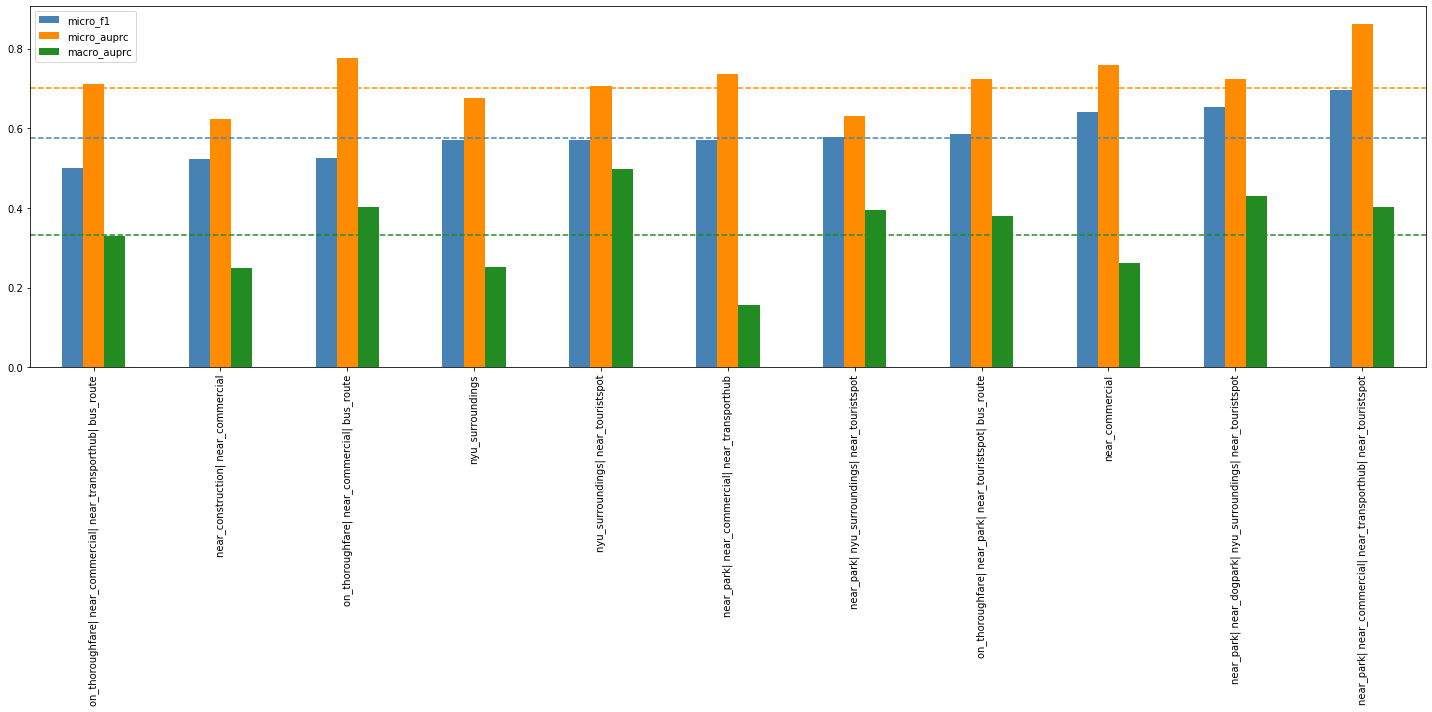

In [72]:
# Group by the sensor metadata and plot distribution per group                            
grouped_df = meta_df.groupby(cols)['sensor_name']

# Generate the pdf
grp_pdf_path = os.path.join(DATA_FOLDER, 'meta_grp_metric_{}.pdf'.format(version))
plt.rcParams.update({'font.size': 10})

overall_df = pd.read_csv(overall_pred_path)   
metrics = ['micro_f1', 'micro_auprc', 'macro_auprc']
colors = ['steelblue', 'darkorange', 'forestgreen']
    
grp_metrics = {}
mlist = np.zeros(len(metrics), dtype=np.float32)
n_sensors = 0

for i, (grp, df_group) in enumerate(grouped_df):
    sensors = df_group.values
    grp_lst = [c for c, g in zip(cols, grp) if g > 0 and c!='nyu_location'] 
    grp_name = '| '.join(grp_lst)
    test = overall_df[overall_df['sensor_name'].isin(sensors)]
    if len(test) > 0:
        grp_metrics[grp_name] = {}
        n_sensors += len(test) 
        for i, metric in enumerate(metrics):
            mlist[i] += np.sum(test[metric])
            grp_metrics[grp_name][metric] = np.mean(test[metric])

fig, ax = plt.subplots(figsize=(20, 10))
grp_metrics_df = pd.DataFrame.from_dict(grp_metrics, orient='index', columns=metrics)
grp_metrics_df = grp_metrics_df.sort_values(by=['micro_f1'])
grp_metrics_df.plot.bar(ax=ax, color=colors)
x_min, x_max = ax.get_xlim()
for i, metric in enumerate(metrics):
    plt.hlines(mlist[i]/n_sensors, xmin=x_min, xmax=x_max, color=colors[i], ls='--')
    
plt.tight_layout()
plt.savefig(grp_pdf_path)